In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# remove the SettingWithCopyWarning

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
parameter = "alpha0.3_k20_res0.005"

pg = f"../data/07-clustered-graphs/{parameter}.graphml"
G = nx.read_graphml(pg)
pdf = f"../data/06-clustered-df/{parameter}.pkl"
df = pd.read_pickle(pdf)

# pcd = f"../output/tables/cluster-explorer/SingleSolExplorer_{parameter}.xlsx"
## first sheet is the cluster details
# cluster_details = pd.read_excel(pcd, sheet_name=0)

In [5]:
p = "/Users/jlq293/Projects/Study-1-Bibliometrics/output/orlando/OrlandoSingleSolExplorer_alpha0.3_k20_res0.005.xlsx"
df_summary_labeled = pd.read_excel(p, sheet_name="summary")
cluster_label_dict = dict(
    zip(df_summary_labeled["Cluster"].astype(str), df_summary_labeled["Given Label"])
)
cluster_label_dict

{'0': 'ocd, treatment, extension',
 '1': 'pregnancy, safety, special population',
 '2': 'determine drugs, detection, Pharmacology; Analytical Chemistry, clinical, plasma, analytical methods for the simultaneous determination and quantification of antidepressant drugs in various biological samples',
 '3': 'chronic unpredictable mild stress in mice, animal models, natural medicine, pharmacology, animal studies',
 '4': 'Serotonin modulation and antidepressant mechanisms, receptor, in vivo, animal models',
 '5': 'Pharmacokinetic interactions between antidepressants and the cytochrome P450 system; Pharmacology; Drug metabolism',
 '6': 'Environmental impact of fluoxetine on aquatic organisms, particularly fish, ecotoxicology, fluoxetine',
 '7': 'Environmental Science; wastewater',
 '8': 'Developmental and prenatal exposure to fluoxetine and maternal stress; pharmacology, animal models,',
 '9': 'prescription patterns, public health, ',
 '10': 'ptsd, indication extension',
 '11': 'sexual dysfu

# Prepare


In [6]:
def process_given_labels(summary_df, n_words=5):
    cols = [col for col in summary_df.columns if col.startswith("Word_")]
    word_cols = cols[:n_words]
    summary_df["Given Label"] = summary_df[word_cols].apply(
        lambda row: "; ".join(list(set(row.values))), axis=1
    )
    # add cluster number to the given label
    summary_df["Given Label"] = summary_df[["Cluster", "Given Label"]].apply(
        lambda row: f"{str(row['Cluster'])}: {row['Given Label']}", axis=1
    )
    # remove cols
    summary_df = summary_df.drop(columns=cols)
    return summary_df


summary_df = process_given_labels(cluster_details, n_words=3)
# cluster_label_dict = dict(zip(summary_df["Cluster"], summary_df["Given Label"]))
summary_df.head(3)

NameError: name 'cluster_details' is not defined

# VISUALS


# Interactive visualization


In [37]:
class InteractiveProportionsPlotter:
    """
    A class to visualize cluster proportions over time using Plotly.
    """

    def __init__(
        self,
        df,
        cluster_label_dict,
        year_col="year",
        cluster_col="cluster_alpha0.3_k10_res0.002",
    ):
        self.df = df
        self.year_col = year_col
        self.cluster_col = cluster_col
        self.cluster_label_dict = cluster_label_dict

    def plot_proportions(
        self,
        cluster_subset_list,
        figsize=(10, 6),
        proportions_total="total",
        save=False,
    ):
        cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )

        subset_cluster_counts = cluster_counts[
            cluster_counts[self.cluster_col].isin(cluster_subset_list)
        ]

        # Calculate yearly totals for normalization
        if proportions_total == "total":
            yearly_totals = cluster_counts.groupby(self.year_col)["count"].transform(
                "sum"
            )
            y_label = "Proportion of Total"
        elif proportions_total == "subset":
            yearly_totals = subset_cluster_counts.groupby(self.year_col)[
                "count"
            ].transform("sum")
            y_label = "Proportion of Subset Total"

        subset_cluster_counts["proportion"] = (
            subset_cluster_counts["count"] / yearly_totals
        )

        long_df = (
            subset_cluster_counts.pivot(
                index=self.year_col, columns=self.cluster_col, values="proportion"
            )
            .fillna(0)
            .reset_index()
            .melt(id_vars=[self.year_col], var_name="Cluster", value_name="Proportion")
        )
        # make cluster col a string
        long_df["Cluster"] = long_df["Cluster"].astype(str)

        long_df["Cluster"] = long_df["Cluster"].map(self.cluster_label_dict)

        fig = px.area(
            long_df,
            x=self.year_col,
            y="Proportion",
            color="Cluster",
            title="Cluster Proportions Over Time",
            labels={self.year_col: "Year", "Proportion": y_label},
            width=figsize[0] * 100,
            height=figsize[1] * 100,
        )

        fig.update_layout(
            dict(
                updatemenus=[
                    dict(
                        type="buttons",
                        direction="left",
                        buttons=list(
                            [
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle",
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle",
                                ),
                            ]
                        ),
                        pad={"r": 10, "t": 10},
                        showactive=False,
                        x=1,
                        xanchor="right",
                        y=1.1,
                        yanchor="top",
                    ),
                ]
            )
        )

        fig.show()
        if save == True:
            fig.write_html(
                "/Users/jlq293/Projects/Study-1-Bibliometrics/output/figures/cluster_proportions.html"
            )

In [38]:
# Example usage
plotter = InteractiveProportionsPlotter(
    df,
    cluster_label_dict=cluster_label_dict,
    year_col="year",
    cluster_col=f"cluster_{parameter}",
)


plotter.plot_proportions(
    cluster_subset_list=list(range(len(df))),
    figsize=(15, 8),
    proportions_total="total",
    save=True,
)
plotter.plot_proportions(
    cluster_subset_list=list(range(10)), figsize=(15, 8), proportions_total="subset"
)

# StaticProportionsPlotter


In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


class StaticProportionsPlotter:
    def __init__(
        self,
        df,
        cluster_label_dict,
        cluster_col="cluster",
        year_col="year",
        font_name="Arial",
        font_size=12,
    ):
        self.df = df
        self.cluster_label_dict = cluster_label_dict
        self.cluster_col = cluster_col
        self.year_col = year_col
        self.font_name = font_name
        self.font_size = font_size

    def _calculate_cluster_proportions_per_year(self):
        """
        This creates a df in long format with the counts of papers per cluster per year.
        """
        cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )
        cluster_proportions = cluster_counts.groupby(self.year_col)["count"].transform(
            "sum"
        )

        cluster_counts["proportion"] = cluster_counts["count"] / cluster_proportions

        self.cluster_counts = cluster_counts

    def _calculate_subset_cluster_proportions_per_year(self, clusters_to_plot):
        """
        filters the cluster counts to only include the selected clusters and calculates the proportions. also calculates the total proportions for the selected subset. uses this as top y axis
        """
        # Calculate proportions for the selected subset
        filtered_cluster_counts = self.cluster_counts[
            self.cluster_counts[self.cluster_col].isin(clusters_to_plot)
        ]
        subset_proportions = filtered_cluster_counts.groupby(self.year_col)[
            "count"
        ].transform("sum")
        filtered_cluster_counts["proportion"] = (
            filtered_cluster_counts["count"] / subset_proportions
        )
        return filtered_cluster_counts

    def _set_x_axis_ticks_and_limits(self, ax, pivot_df):
        """
        Set x-axis ticks and limits based on the range of years in the DataFrame.
        """
        min_year = pivot_df.index.min()
        max_year = pivot_df.index.max()

        # Calculate the range of years to include ticks
        start_year = min_year - 1
        end_year = max_year + 1

        # Calculate the ticks every 5 years within the range
        years = np.arange(start_year, end_year, 5)

        # Ensure the min and max years are included in the ticks
        years = np.append(years, max_year)
        years = np.insert(years, 0, min_year)

        ax.set_xticks(years)

        # Set x-axis limits with a buffer of 0.2 years
        ax.set_xlim(min_year - 0.2, max_year + 0.2)

    def plot_cluster_proportions(
        self,
        clusters_to_plot: list,
        proportions_total="total",
    ):
        """
        Plots the cluster proportions over time. The total proportion can either be the overall total or the total of the selected subset.

        """
        if not hasattr(self, "cluster_counts"):
            self._calculate_cluster_proportions_per_year()

        if proportions_total == "total":
            # Use overall proportions
            filtered_cluster_counts = self.cluster_counts.copy()
            yaxis_label = "Proportion (Overall)"
        elif proportions_total == "subset":
            filtered_cluster_counts = (
                self._calculate_subset_cluster_proportions_per_year(clusters_to_plot)
            )
            yaxis_label = "Proportion (Subset)"

        pivot_df = filtered_cluster_counts.pivot(
            index=self.year_col, columns=self.cluster_col, values="proportion"
        ).fillna(0)

        # Plot only the selected clusters
        pivot_df = pivot_df[clusters_to_plot]

        # Extract labels for the clusters being plotted
        cluster_labels = [
            self.cluster_label_dict[cluster] for cluster in clusters_to_plot
        ]

        colors = plt.cm.tab20.colors[: len(clusters_to_plot)]

        # Create an area plot using Matplotlib
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.stackplot(
            pivot_df.index, pivot_df.values.T, labels=cluster_labels, colors=colors
        )

        ax.set_ylabel(yaxis_label, fontsize=self.font_size, fontname=self.font_name)
        ax.set_title(
            "Cluster Proportions Over Time",
            fontsize=self.font_size,
            fontname=self.font_name,
        )
        ax.legend(
            title="Cluster",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            fontsize=self.font_size,
            title_fontsize=self.font_size,
        )

        self._set_x_axis_ticks_and_limits(ax, pivot_df)

        # Set font for tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname(self.font_name)
            label.set_fontsize(self.font_size)
        # plt.tight_layout()
        # plt.savefig("output.png", dpi=300)
        plt.show()

In [39]:
cluster_label_dict = "/Users/jlq293/Projects/Study-1-Bibliometrics/output/orlando/ORLANDOSingleSolExplorer_alpha0.3_k20_res0.005.xlsx"
cluster_label_dict = pd.read_excel(cluster_label_dict, sheet_name="summary")

# remove where key is not numeric
cluster_label_dict = cluster_label_dict[
    cluster_label_dict["Cluster"].apply(lambda x: str(x).isnumeric())
]

cluster_label_dict = dict(
    zip(cluster_label_dict["Cluster"].astype(str), cluster_label_dict["Given Label"])
)

In [40]:
expansion = {
    "0": "ocd, treatment, extension",
    "10": "ptsd, indication extension",
    "21": "pain, indication extension, treatment",
    "25": "weight management, treatment, indication extension",
    "31": "panic disorder, treatment, indication extension, ",
    "35": "anxiety, indication extension, treatment, ",
    "39": "psychodermatology, treatment, indication extension, ",
    "41": "alcoholism, treatment, indication extension, ",
    "42": "ibs,  treatment, indication extension, ",
    "43": "premature ejaculation, treatment, indication extension",
    "45": "sleep, treatment",
    "46": "eating, treatment, indication extension",
    "52": "bipolar, treatment, ",
    "55": "hot flashes, women , special population, treatment, indication extension",
    "63": "anxiety, treatment, indication extension, ",
    "61": "schizophrenia, treatment, indication extension,adjunctive therapy, review",
    "69": "autism, indication extension, children, adolescents,treatment",
    "93": "anxiety, pediatrics, paediatrics, children, review, treatment,",
    "96": "pathological laughing, neuroscience, clinical, treatment, indication extension",
    "99": "seasonal affective disorder sad, treatment, clinical, indication extension",
    "110": "migraine, headache, neuroscience,treatment, indication extension,",
    "111": "stress urinary incontinence (SUI), geriatrics, indication extension, treatment,",
    "118": "treatment, indication expansion, tics, tourette, ",
    "122": "dysthymia, treatment, clinical, review",
}

special_population = {
    "13": "children and adolescents, Pediatrics, special population",
    "22": "special populations, treatment, depression, clnical,",
    "26": "dementia, geriatrics, alzheimer, special population, treatment, depression",
    "38": "cancer, special population, oncology, oncoprevention, in vitro, ",
    "48": "parkinsion, geriatrics, special population",
    "56": "diabetes, special population, treatment, depression, ",
    "67": "epilepsy, special population, review",
    "68": "review, children, adolescents, prescription, safety, ",
    "70": "pmdd, indication extension, treatment,",
    "83": "geriatrics, depression, treatment, overview, review",
    "86": "liver, safety, treatment",
    "87": "bpd, treatment, indication extension, ",
    "93": "anxiety, pediatrics, paediatrics, children, review, treatment,",
    "102": "fibromyalgia, pain, indication extension, ",
    "106": "depression, cancer, special population, oncology, ",
    "114": "depression,kidney, special population, ",
}


safety = {
    "1": "pregnancy, safety, special population",
    "11": "sexual dysfunction, safety, side effect, ",
    "17": "safety, serotonin syndrome, treatment, ",
    "18": "cardiovascular, safety, treatment",
    "28": "suicide, safety, depression, pharmacovigilance, review, treatment, ",
    "33": "bleeding, safety, pharmacovigilance, treatment,",
    "37": "fracture, safety, pharmacovigilance,  geriatrics",
    "49": "drug/drug interaction, treatment, geriatrics, ",
    "50": "intoxication, safety, overdose, ",
    "68": "review, children, adolescents, prescription, safety, ",
    "71": "qtc, cardiology, safety,",
    "82": "hyponatremia, geriatrics, safety, treatment",
    "86": "liver, safety, treatment",
    "90": "withdrawal, safety, treatment,",
    "92": "lactation, breastfeeding, special population, review, children,",
    "100": "safety, review adverse effects, ",
    "115": "glaucoma, safety, treatment, ",
    "129": "galactorrhea, safety, advere effect, treatment, clinical, paroxetine",
}

drug_focus = {
    "60": "venlafaxine, ssri, depression, review",
    "66": "escitalopram, review, depression, ",
    "79": "citalopram, treatment, overview, review, ",
    "84": "sertraline, review, efficacy,",
    "105": "vilazodone, clinical, review, depression",
    "116": "agomelatine, depression, review, trials, ",
}

In [52]:
safety_clusters_labels = {
    "1": "pregnancy",
    "17": "serotonin syndrome",
    "18": "cardiovascular risk",
    "71": "cv risk-qtc prolongation",
    "28": "suicide risk",
    "68": "pediatric safety",
    "11": "sexual dysfunction",
    "33": "bleeding risk",
    "37": "fracture  risk",
    "49": "drug/drug interaction",
    # "50": "intoxication",
    # "82": "Hyponatremia",
    # "86": "Liver",
    "90": "Withdrawal symtpoms",
    # "92": "Lactation",
    # "100": "Adverse Effect Reviews",
    # "115": "glaucoma risk",
    # "129": "galactorrhea risk",
}

# make text to title and key to int

safety_clusters_labels = {int(k): v.title() for k, v in safety_clusters_labels.items()}

safety_clusters = list(safety_clusters_labels.keys())

# Example usage
spp = StaticProportionsPlotter(
    df,
    safety_clusters_labels,
    cluster_col=f"cluster_{parameter}",
    font_name="Arial",
    font_size=12,
)

In [53]:
clusters_to_plot = [str(i) for i in range(0, 15)]
spp.plot_cluster_proportions(
    clusters_to_plot=safety_clusters,
    proportions_total="total",
)

AttributeError: 'StaticProportionsPlotter' object has no attribute 'plot_cluster_proportions'

In [102]:
class StaticProportionsPlotter:
    def __init__(
        self,
        df,
        cluster_label_dict,
        cluster_col="cluster",
        year_col="year",
        font_name="Arial",
        font_size=26,
        cluster_mergers=[(23, 125)],
    ):
        self.df = df
        self.cluster_label_dict = cluster_label_dict
        self.cluster_col = cluster_col
        self.year_col = year_col
        self.font_name = font_name
        self.font_size = font_size
        self.merge_clusters(cluster_mergers)

    def merge_clusters(self, cluster_mergers):
        """
        Merges clusters based on the specified dictionary.
        """
        for merge in cluster_mergers:
            self.df[self.cluster_col] = self.df[self.cluster_col].replace(
                {merge[1]: merge[0]}
            )

    def _calculate_cluster_proportions_per_year(self):
        """
        This creates a df in long format with the counts of papers per cluster per year.
        """
        cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )
        cluster_proportions = cluster_counts.groupby(self.year_col)["count"].transform(
            "sum"
        )

        cluster_counts["proportion"] = cluster_counts["count"] / cluster_proportions

        self.cluster_counts = cluster_counts

    def _calculate_subset_cluster_proportions_per_year(self, clusters_to_plot):
        """
        filters the cluster counts to only include the selected clusters and calculates the proportions. also calculates the total proportions for the selected subset. uses this as top y axis
        """
        # Calculate proportions for the selected subset
        filtered_cluster_counts = self.cluster_counts[
            self.cluster_counts[self.cluster_col].isin(clusters_to_plot)
        ]
        subset_proportions = filtered_cluster_counts.groupby(self.year_col)[
            "count"
        ].transform("sum")
        filtered_cluster_counts["proportion"] = (
            filtered_cluster_counts["count"] / subset_proportions
        )
        return filtered_cluster_counts

    def _set_x_axis_ticks_and_limits(self, ax, pivot_df):
        """
        Set x-axis ticks and limits based on the range of years in the DataFrame.
        """
        min_year = pivot_df.index.min()
        max_year = pivot_df.index.max()

        # Calculate the range of years to include ticks
        start_year = min_year - 1
        end_year = max_year + 1

        # Calculate the ticks every 5 years within the range
        years = np.arange(start_year, end_year, 5)

        # Ensure the min and max years are included in the ticks
        years = np.append(years, max_year)
        years = np.insert(years, 0, min_year)

        ax.set_xticks(years)

        # Set x-axis limits with a buffer of 0.2 years
        ax.set_xlim(min_year - 0.2, max_year + 0.2)

        # roate x labels
        plt.xticks(rotation=45)

    def plot_cluster_proportions_with_rolling_means(
        self,
        clusters_to_plot: list,
        window_size: int,
        proportions_total="total",
        savepath=None,
    ):
        """
        Plots the cluster proportions over time with rolling means.
        The total proportion can either be the overall total or the total of the selected subset.
        """
        if not hasattr(self, "cluster_counts"):
            self._calculate_cluster_proportions_per_year()

        if proportions_total == "total":
            # Use overall proportions
            filtered_cluster_counts = self.cluster_counts.copy()
            yaxis_label = "Proportion (Overall)"
        elif proportions_total == "subset":
            filtered_cluster_counts = (
                self._calculate_subset_cluster_proportions_per_year(clusters_to_plot)
            )
            yaxis_label = "Proportion (Subset)"

        pivot_df = filtered_cluster_counts.pivot(
            index=self.year_col, columns=self.cluster_col, values="proportion"
        ).fillna(0)

        # Plot only the selected clusters
        pivot_df = pivot_df[clusters_to_plot]

        # Calculate rolling means for each cluster
        pivot_df_rolling = pivot_df.rolling(window=window_size, min_periods=1).mean()

        # Extract labels for the clusters being plotted
        cluster_labels = [
            self.cluster_label_dict[cluster] for cluster in clusters_to_plot
        ]

        colors = plt.cm.tab20.colors[: len(clusters_to_plot)]

        # Create an area plot with rolling means using Matplotlib
        fig, ax = plt.subplots(figsize=(20, 8))

        # Calculate the rolling mean for the entire DataFrame for the background plot
        pivot_df_rolling_all = pivot_df.rolling(
            window=window_size, min_periods=1
        ).mean()

        ax.stackplot(
            pivot_df_rolling_all.index,
            [pivot_df_rolling_all[col] for col in pivot_df_rolling_all.columns],
            labels=[],  # Disable legend for the background plot
            colors=colors,
            alpha=0.5,  # Set transparency for the background plot
        )

        # Plot the rolling means for selected clusters
        stack = ax.stackplot(
            pivot_df_rolling.index,
            [pivot_df_rolling[col] for col in pivot_df_rolling.columns],
            labels=cluster_labels,
            colors=colors,
            alpha=1,  # Set full opacity for the main plot
        )

        ax.set_ylabel(yaxis_label, fontsize=self.font_size, fontname=self.font_name)
        # ax.set_title(
        #    "Cluster Proportions Over Time with Rolling Means",
        #    fontsize=self.font_size,
        #    fontname=self.font_name,
        # )

        # reverse order of legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            # reversed(handles),
            # reversed(labels),
            handles,
            labels,
            title="Legend",
            bbox_to_anchor=(-0.045, -0.15),
            loc="upper left",
            fontsize=self.font_size,
            title_fontsize=self.font_size,
            ncol=3,
        )

        self._set_x_axis_ticks_and_limits(ax, pivot_df)

        # Set font for tick labels
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname(self.font_name)
            label.set_fontsize(self.font_size)

        # plt.tight_layout()
        if savepath:
            plt.savefig(savepath, dpi=300, bbox_inches="tight")

        plt.show()

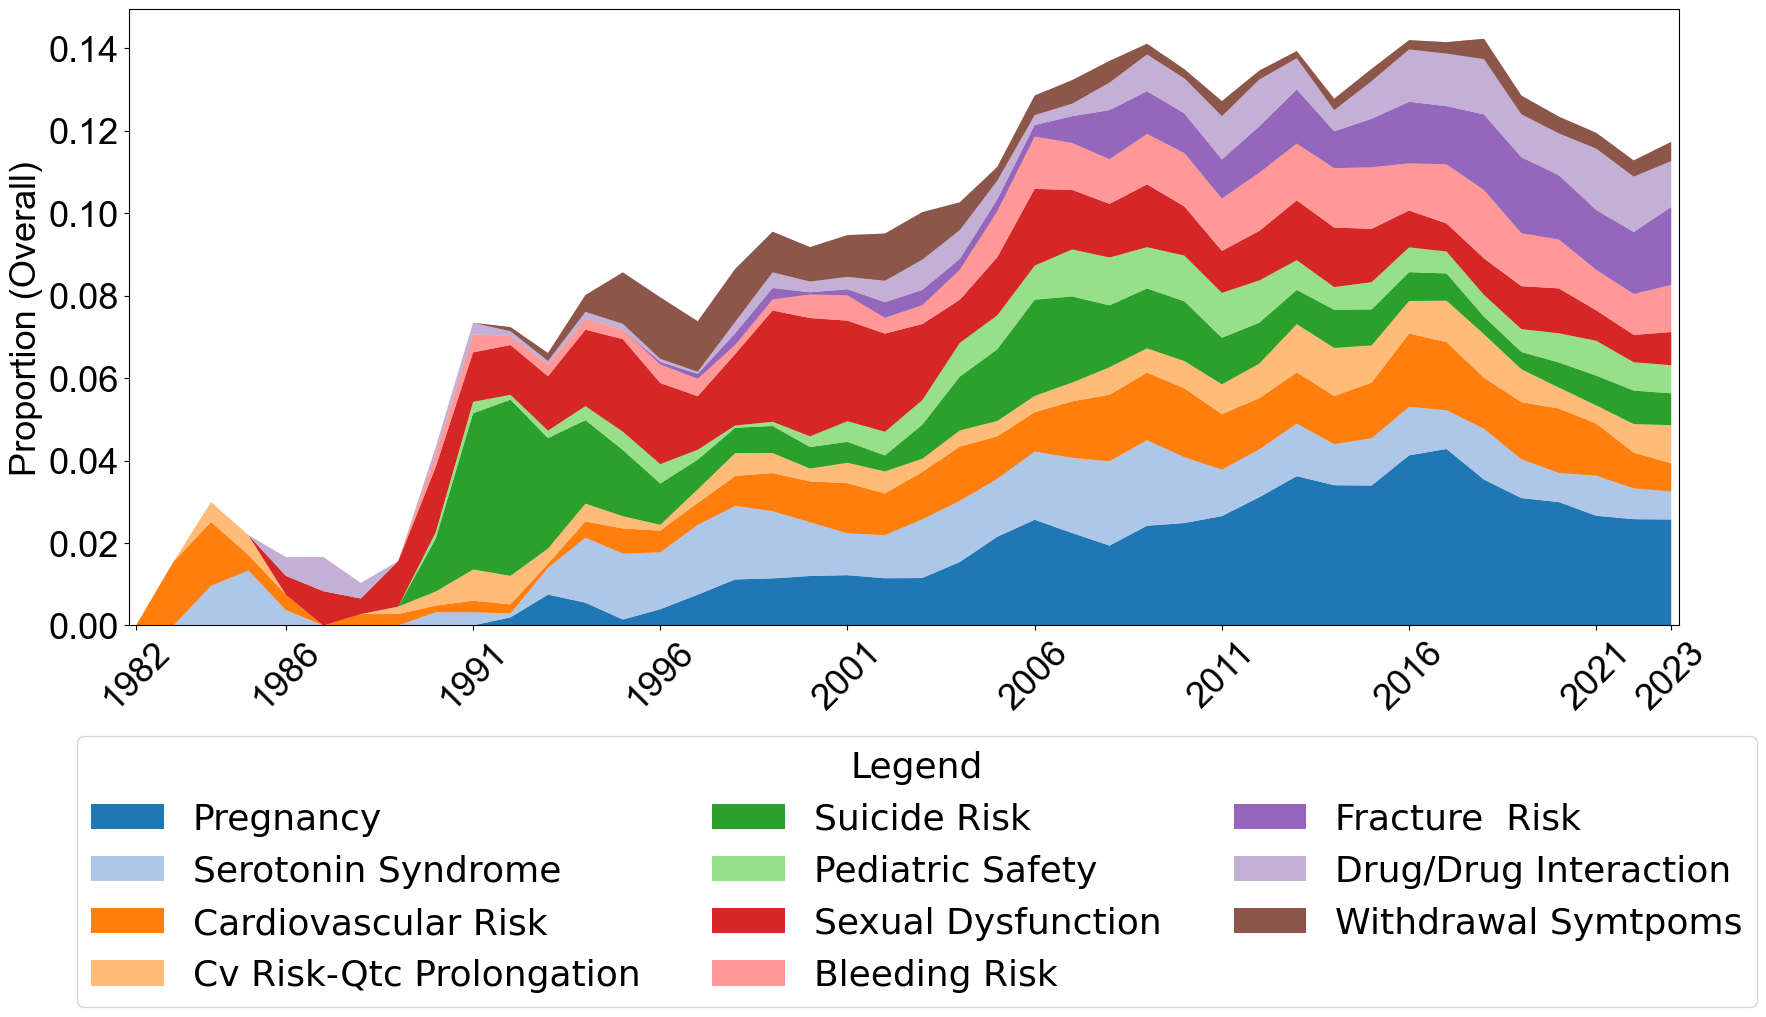

In [103]:
# Example usage:
# Assuming you have already instantiated StaticProportionsPlotter and have your data loaded into `df`:
plotter = StaticProportionsPlotter(
    df,
    safety_clusters_labels,
    cluster_col=f"cluster_{parameter}",
)
plotter.plot_cluster_proportions_with_rolling_means(
    clusters_to_plot=safety_clusters,
    window_size=2,
    savepath="/Users/jlq293/Projects/Study-1-Bibliometrics/output/orlando/safety_cluster_proportions_rolling_means.png",
)